## Fake News Detection Project

With the benefit of the Internet technology, information travels faster than ever before. However, it has also been simpler for people with ulterior motives to manipulate public opinion by spreading false information and pretending to be a reputable source. Therefore, we would like to explore methods using text mining techniques to identify fake news.

**Objective:** Develop Fake News detection model with Natural Language Processing Techniques

**Data Source:** https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

### **Step1:** Develop dataset with news under politics news category

In [3]:
import re
import codecs
import nltk
import random
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In each csv file, it contains 4 identical columns: Title, Text(main body of the article), Subject(News category) and Date. There are 23,482 rows in the fake news dataset and 21,418 rows in the true news dataset. In this project, we will use politics news category to train the model. 

Also, some news only contain image or video as the main body, so we will exclude these news since our main purpose is to analyze the text in this project.

In [5]:
trueset=[]
count=0
t_error=[]

with open("True_political.csv",'r') as t:
    true = t.readlines()
    true = true[1:]
    for i in true:
        news=[]
        title=re.findall('^"?(.*?)"?,"',i)
        content=re.findall(',"(.*?)"?,politicsNews',i)
        try:
            news.append(title[0])
            news.append(content[0])
            trueset.append(news)
        except:
            t_error.append(count)
        count+=1
print(f'Number of Real news appended: %d' %len(trueset))

Number of Real news appended: 11213


In [6]:
fakeset=[]
count=0
f_error=[]

with open("Fake_political.csv",'r') as f:
    fake = f.readlines()
    fake = fake[1:]
    for i in fake:
        news=[]
        title=re.findall('^"?(.*?)"?,"',i)
        content=re.findall(',"(.*?)"?,politics',i)
        try:
            news.append(title[0])
            news.append(content[0])
            fakeset.append(news)
        except:
            f_error.append(count)
        count+=1
print(f'Number of Fake news appended: %d' %len(fakeset))

Number of Fake news appended: 5840


## Word Frequency and Word Cloud of Real and Fake news

Before moving forward to extract feature, we could check out the most frequency words and create a Word Cloud to visualize the text data to do a bit comparsion with the word choice.

### Word Frequency for Real News

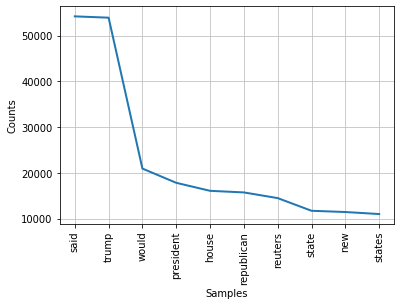

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from nltk.corpus import stopwords

stopwords=stopwords.words("english")
true_join=' '.join([' '.join(x) for x in trueset])
true_word_list=nltk.word_tokenize(true_join.lower())
remove_stopword=[i for i in true_word_list if i not in stopwords if i.isalnum()]
nltk.FreqDist(remove_stopword).plot(10)

### Word Frequency for Fake News

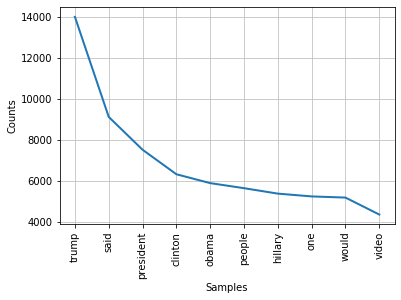

In [27]:
fake_join=' '.join([' '.join(x) for x in fakeset])
fake_word_list=nltk.word_tokenize(fake_join.lower())
f_remove_stopword=[i for i in fake_word_list if i not in stopwords if i.isalnum()]
nltk.FreqDist(f_remove_stopword).plot(10)

As we can see, politicians' names and specific terms, such as *Trump* and *president*, have high frequency both in True and Fake news content. 

On the other hand, *video* has an oddly high frequency in fake news dataset, which could be one of the clickbait keywords to attract readers.

### Word Cloud for True and Fake News

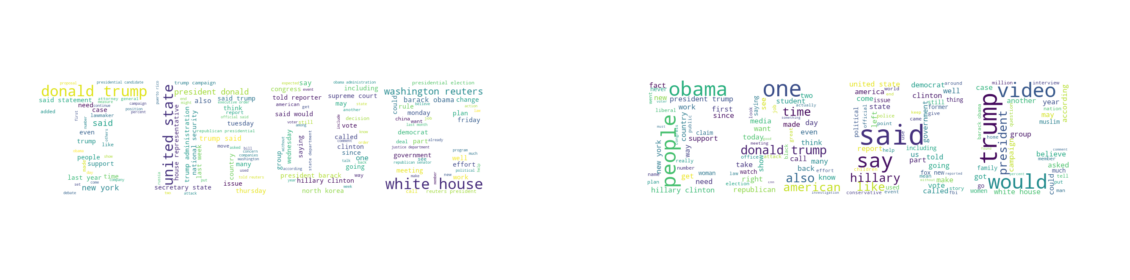

In [30]:
fig = plt.figure(figsize=(20,12))
f1 = fig.add_subplot(1,2,1)
true_mask = np.array(Image.open("true-image1.jpg"))
WordCloud_true=' '.join(remove_stopword)
wc1=WordCloud(background_color="white", stopwords=stopwords,mask=true_mask, max_words=150,max_font_size=150,width=1200, height=630).generate(WordCloud_true)
f1.imshow(wc1,interpolation='bilinear')
f1.axis('off')
f2 = fig.add_subplot(1,2,2)
true_mask = np.array(Image.open("fake-image1.jpg"))
WordCloud_fake=' '.join(f_remove_stopword)
wc2=WordCloud(background_color="white", stopwords=stopwords,mask=true_mask, max_words=150,max_font_size=150,width=1200, height=630).generate(WordCloud_fake)
f2.imshow(wc2,interpolation='bilinear')
f2.axis('off')
plt.show()

### Step2: Develop function that could extract linguistic features for each news

To classify the news as fake or real news, I implemented the linguistic approach, extracting specific linguistic and text sentiment features for each news title and content:

* **Exclamation mark:** The existence of Exclamation mark in news title

* **Capitalized words in title:** Number of capitalized words / Number of words in title

* **Arousing words in content:** Number of arousing words / Number of words in content

* **Capitalzed words in content:** Number of Capitalized words / Number of words in content

* **Positive Sentiment:** Polarity Score measuring positivity of content

* **Neutral Sentiment:** Polarity Score measuring neutrality of content

* **Negative Sentiment:** Polarity Score measuring negativity of content

* **Subjectivity:** Metric measuring the subjectivity of content

#### import arousal words as list 

In [9]:
arousal=[]

with codecs.open('arousal.txt','r',encoding= u'utf-8',errors='ignore') as f:
    arousal_clean=[re.sub('#_?[\d]{1,2}','',x.strip('\r\n').lower()) for x in f.readlines()]
    for i in arousal_clean:
        if i in arousal:
            continue
        else:
            arousal.append(i)
print(arousal[0:5])

['abhor', 'acrimonious', 'acrimony', 'adamant', 'affection']


#### Define feature function

In [10]:
analyzer = SentimentIntensityAnalyzer()
def feature_function(title,content):
    #subjectivity
    blob=TextBlob(content)
    #sentiment score
    score=analyzer.polarity_scores(content)
    #count capitalized word in title
    tcap_word = re.findall('[A-Z]{2,}',title)
    title_clean = re.sub('[!"#$%&\'\(\)*\+,-\.\/:;<=>?@\[\]\\^_`{|}~]',' ',title)
    title_count = len(nltk.word_tokenize(title_clean))
    #count capitalized word in content
    cap_word = re.findall('[A-Z]{2,}',content)
    content_clean = re.sub('[!"#$%&\'\(\)*\+,-\.\/:;<=>?@\[\]\\^_`{|}~]',' ',content)
    content_count = len(nltk.word_tokenize(content_clean))
    #arousal word percentage
    arousal_count=sum([1 if i in arousal else 0 for i in nltk.word_tokenize(content_clean)])
    return {'t_exclaim':'!' in title,
            't_cap':len(tcap_word)/title_count,
            'c_cap':len(cap_word)/content_count,
            'c_subj':blob.sentiment.subjectivity,
            'c_pos':score['pos'],
            'c_neg':score['neg'],
            'c_neu':score['neu'], 
            'arousal':arousal_count/content_count}

In [12]:
#test
feature_function(trueset[0][0],trueset[0][1])

{'t_exclaim': False,
 't_cap': 0.0,
 'c_cap': 0.007518796992481203,
 'c_subj': 0.41025000000000006,
 'c_pos': 0.085,
 'c_neg': 0.048,
 'c_neu': 0.867,
 'arousal': 0.012531328320802004}

### Step3: Develop Featureset from data sampling from TrueNews and FakeNews set

2,000 news are randomly sampled from real and fake political news datasets respectively for model training and testing.

After applying the feature function with classification labels to each sampled dataset, we then combined two featuresets into one and shuffled the records into random order. 90% of the featureset is utilized for training classification models while 10% for testing.

In [13]:
#sample data from true news dataset
t_index=random.sample(range(len(trueset)), k=2000)
t_sample=[]
for i in t_index:
    t_sample.append(trueset[i])
    
#build FeatureSet for True news
t_featureset=[(feature_function(t,c),'true') for t,c in t_sample]
t_featureset[0]

({'t_exclaim': False,
  't_cap': 0.08333333333333333,
  'c_cap': 0.004807692307692308,
  'c_subj': 0.35100250626566415,
  'c_pos': 0.103,
  'c_neg': 0.086,
  'c_neu': 0.811,
  'arousal': 0.0},
 'true')

In [14]:
#sample data from fake news dataset
f_index=random.sample(range(len(fakeset)), k=2000)
f_sample=[]
for i in f_index:
    f_sample.append(fakeset[i])

#build FeatureSet for Fake news
f_featureset=[(feature_function(t,c),'fake') for t,c in f_sample]
f_featureset[0]

({'t_exclaim': False,
  't_cap': 0.3125,
  'c_cap': 0.0020242914979757085,
  'c_subj': 0.4396386483886484,
  'c_pos': 0.108,
  'c_neg': 0.109,
  'c_neu': 0.784,
  'arousal': 0.004723346828609987},
 'fake')

In [15]:
#Combine together as one featureset
featureset = f_featureset + t_featureset
print(f'Number of rows in featureset are %d' %len(featureset))

Number of rows in featureset are 4000


In [16]:
#shuffle the featureset for splitting the training and validation set
random.shuffle(featureset)
proportion=int(0.9*(len(featureset)))
trainingset=featureset[:proportion]
testingset=featureset[proportion:]

### Step4: Train with different algorithms and compare the result

This document only keeps the 2 algorithms with the highest accuracy. Please refer to the slide and term paper for other tested algorithms.

In [21]:
#NaiveBayes
NB=nltk.NaiveBayesClassifier.train(trainingset)
print(f'Accuracy of Naive Bayes Classifier: %.2f' %nltk.classify.accuracy(NB,testingset))

Accuracy of Naive Bayes Classifier: 0.92


This is the method with highest accuracy, so I want to also check the Most Informative Features.

In [20]:
NB.show_most_informative_features(10)

Most Informative Features
               t_exclaim = True             fake : true   =    307.5 : 1.0
                   t_cap = 0.2              fake : true   =     38.5 : 1.0
                   t_cap = 0.0              true : fake   =     23.3 : 1.0
                   t_cap = 0.2727272727272727   fake : true   =     14.8 : 1.0
                   t_cap = 0.2222222222222222   fake : true   =      7.8 : 1.0
                   c_neg = 0.121            fake : true   =      7.7 : 1.0
                   t_cap = 0.18181818181818182   fake : true   =      7.7 : 1.0
                   c_cap = 0.009433962264150943   true : fake   =      7.1 : 1.0
                   t_cap = 0.16666666666666666   fake : true   =      7.0 : 1.0
                   c_neg = 0.144            fake : true   =      6.9 : 1.0


It shows that the news with "!" in the title are **307.5 times more likely** to be fake news than the real one. 

Also, the percentage of capitalized words existing in a news title and the negative polarity score are also good indicator for identifying fake news.

In [22]:
#logistic regression

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression

logit=SklearnClassifier(LogisticRegression())
logit_train=logit.train(trainingset)
print(f'Accuracy of logistic regression: %.2f' %nltk.classify.accuracy(logit_train,testingset))

Accuracy of logistic regression: 0.90


### Further Reading: 
Complete Term paper collaborated with Hui Yan and Vivian Jiang can be found at <a href="https://9974e33e-e989-4fea-8fab-b3fb9af14652.usrfiles.com/ugd/9974e3_5a8b9c134ecc4e6fafb20a8334c0ac66.pdf" target="_blank">this link</a>.